### 作者：东哥起飞

### 本篇文章来源于[《100天成为风控专家》](https://app7hmmvkwr2019.h5.xiaoeknow.com/p/course/ecourse/course_2ZAoFMNREbOv3DutKsoIi9Vlfky) 贷前策略篇-规则的D类调优(2):Python实操

In [620]:
import pandas as pd
import numpy as np
import scorecardpy as sc
from sklearn import tree
from sklearn.tree import _tree
from sklearn import metrics
import seaborn as sns
from matplotlib import pyplot as plt
import os, re, sys
%matplotlib inline
## 设置属性防止中文乱码
plt.rcParams['font.sans-serif'] = [u'SimHei']
plt.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings("ignore")

In [621]:
import sklearn as sk
import matplotlib as mpl
print('python:%s'%(sys.version))
print('sklearn:%s'%(sk.__version__))
print('pandas:%s'%(pd.__version__))
print('numpy:%s'%(np.__version__))
print('matplotlib:%s'%(mpl.__version__))
print('seaborn:%s'%(sns.__version__))
print('scorecardpy:%s'%(sc.__version__))

python:3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
sklearn:1.3.2
pandas:2.0.0
numpy:1.23.5
matplotlib:3.7.1
seaborn:0.12.2
scorecardpy:0.1.9.7


## 1. 通过样本分箱计算

通过分箱观察区间坏账率badrate的大小和lift值，如果badrate有排序性且lift比较高，如高于2以上，视情况考虑将该箱收紧拒绝。

In [622]:
df = pd.read_excel('data_v3.xlsx')
df.shape

(50000, 9)

In [624]:
# 筛选通过样本
df_tg = df.loc[df['is_dlq_30d'].isnull()==False].reset_index(drop=True)
print(df_tg.shape)
# 通过样本整体坏账率
ttbadrate = df_tg.is_dlq_30d.mean()
print('通过样本坏客户浓度:{}%'.format(round(ttbadrate*100,2)))

(45247, 9)
通过样本坏客户浓度:7.95%


In [625]:
# 类型修改（因为有空值需转换否则报错）
df_tg['is_dlq_30d'] = df_tg['is_dlq_30d'].astype(int)
# 去除非分析对象
var = df_tg.columns.difference(['sample_id','sample_month','risk_score']).tolist()

# scorecardpy变量分箱
bins_info = sc.woebin(df_tg[var], y='is_dlq_30d', breaks_list={}, method='tree', stop_limit=0)

# 计算分箱下的lift值（简易版口径：分箱区间坏账率/整体样本平均坏账率）
for k,v in bins_info.items():
    v['lift'] = v['badprob']/ttbadrate
    bins_info[k] = v

# 生成变量的lift表
print('lift提升度计算')
rule_lift = pd.Series({k:v['lift'].max() for k,v in bins_info.items()}).sort_values(ascending=False)
print(rule_lift)

for col in rule_lift.index:
    if col == 'is_dlq_30d':
        continue
    else:
            display(bins_info[col].style.bar(subset=['badprob'], color='lightgreen', width=80, height=80, align='left', vmin=0).highlight_max(subset=['lift'], color='red',axis=0))

[INFO] creating woe binning ...
lift提升度计算
ovd_order_cnt_6m_grade           3.875795
positive_biz_cnt_1y_grade        2.009185
adr_stability_grade              1.891860
last_6m_avg_asset_total_grade    1.799878
repayment_ability_rank           1.365567
dtype: float64


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values,lift
0,ovd_order_cnt_6m_grade,"[-inf,2.0)",37512,0.829049,35837,1675,0.044652,-0.613362,0.241951,0.793710,2.0,False,0.561999
1,ovd_order_cnt_6m_grade,"[2.0,3.0)",4663,0.103057,3689,974,0.208878,1.118106,0.203903,0.793710,3.0,False,2.628963
2,ovd_order_cnt_6m_grade,"[3.0,inf)",3072,0.067894,2126,946,0.307943,1.640050,0.347857,0.793710,inf,False,3.875795


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values,lift
0,positive_biz_cnt_1y_grade,"[-inf,3.0)",5594,0.123633,4701,893,0.159635,0.788861,0.106920,0.286737,3.0,False,2.009185
1,positive_biz_cnt_1y_grade,"[3.0,4.0)",2353,0.052003,2045,308,0.130897,0.556752,0.020364,0.286737,4.0,False,1.647478
2,positive_biz_cnt_1y_grade,"[4.0,5.0)",2837,0.062700,2530,307,0.108213,0.340679,0.008399,0.286737,5.0,False,1.361978
3,positive_biz_cnt_1y_grade,"[5.0,7.0)",6383,0.141070,5770,613,0.096036,0.207743,0.006645,0.286737,7.0,False,1.208722
4,positive_biz_cnt_1y_grade,"[7.0,8.0)",3399,0.075121,3104,295,0.086790,0.096334,0.000726,0.286737,8.0,False,1.092350
5,positive_biz_cnt_1y_grade,"[8.0,9.0)",3711,0.082016,3455,256,0.068984,-0.152595,0.001791,0.286737,9.0,False,0.868240
6,positive_biz_cnt_1y_grade,"[9.0,10.0)",4632,0.102371,4411,221,0.047712,-0.543889,0.024163,0.286737,10.0,False,0.600502
7,positive_biz_cnt_1y_grade,"[10.0,inf)",16338,0.361085,15636,702,0.042967,-0.653592,0.117728,0.286737,inf,False,0.540791


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values,lift
0,adr_stability_grade,"[-inf,3.0)",5422,0.119831,4607,815,0.150314,0.717661,0.083318,0.272240,3.0,False,1.891860
1,adr_stability_grade,"[3.0,4.0)",3135,0.069286,2717,418,0.133333,0.578003,0.029502,0.272240,4.0,False,1.678146
2,adr_stability_grade,"[4.0,5.0)",7474,0.165182,6719,755,0.101017,0.263829,0.012849,0.272240,5.0,False,1.271407
3,adr_stability_grade,"[5.0,6.0)",3995,0.088293,3655,340,0.085106,0.074900,0.000511,0.272240,6.0,False,1.071157
4,adr_stability_grade,"[6.0,7.0)",3522,0.077839,3269,253,0.071834,-0.109045,0.000884,0.272240,7.0,False,0.904112
5,adr_stability_grade,"[7.0,8.0)",6637,0.146684,6225,412,0.062076,-0.265500,0.009252,0.272240,8.0,False,0.781297
6,adr_stability_grade,"[8.0,10.0)",8660,0.191394,8275,385,0.044457,-0.617945,0.056589,0.272240,10.0,False,0.559543
7,adr_stability_grade,"[10.0,inf)",6402,0.141490,6185,217,0.033896,-0.900180,0.079333,0.272240,inf,False,0.426614


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values,lift
0,last_6m_avg_asset_total_grade,"[-inf,2.0)",13496,0.298274,11566,1930,0.143005,0.659256,0.170863,0.878497,2.0,False,1.799878
1,last_6m_avg_asset_total_grade,"[2.0,3.0)",3695,0.081663,3284,411,0.111231,0.371581,0.013184,0.878497,3.0,False,1.399969
2,last_6m_avg_asset_total_grade,"[3.0,4.0)",9602,0.212213,8786,816,0.084982,0.073305,0.001176,0.878497,4.0,False,1.069595
3,last_6m_avg_asset_total_grade,"[4.0,5.0)",3996,0.088315,3792,204,0.051051,-0.472723,0.016212,0.878497,5.0,False,0.642533
4,last_6m_avg_asset_total_grade,"[5.0,6.0)",3421,0.075607,3292,129,0.037708,-0.789633,0.034075,0.878497,6.0,False,0.474600
5,last_6m_avg_asset_total_grade,"[6.0,8.0)",6353,0.140407,6256,97,0.015268,-1.716780,0.211533,0.878497,8.0,False,0.192169
6,last_6m_avg_asset_total_grade,"[8.0,inf)",4684,0.103521,4676,8,0.001708,-3.920951,0.431454,0.878497,inf,False,0.021496


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values,lift
0,repayment_ability_rank,"[-inf,2.0)",15713,0.347272,14910,803,0.051104,-0.471627,0.063481,0.105558,2.0,False,0.643202
1,repayment_ability_rank,"[2.0,3.0)",12113,0.267708,11143,970,0.080079,0.008535,0.000020,0.105558,3.0,False,1.007885
2,repayment_ability_rank,"[3.0,4.0)",4877,0.107786,4416,461,0.094525,0.190214,0.004225,0.105558,4.0,False,1.189704
3,repayment_ability_rank,"[4.0,inf)",12544,0.277234,11183,1361,0.108498,0.343630,0.037832,0.105558,inf,False,1.365567


经观察，`ovd_order_cnt_6m_grade`的lift值大于3，区间坏账远超样本整体坏账率，考虑将其阈值进行收紧调整。

## 2. 策略调整执行

In [590]:
# 配置规则组(规则名，阈值，逻辑关系(gt:大于;lt:小于))
rule_set = []
# 仅对该规则阈值收紧
rule_set.append(('ovd_order_cnt_6m_grade',2,'gt'))
# 其他规则逻辑保持不变
rule_set.append(('last_6m_avg_asset_total_grade',1,'lt'))
rule_set.append(('adr_stability_grade',2,'lt'))
rule_set.append(('positive_biz_cnt_1y_grade',1,'lt'))
rule_set.append(('repayment_ability_rank',4,'gt'))

In [626]:
def ruleset_calc(df:pd.DataFrame, lst:list):
    """
    规则集计算分析函数
    """
    data = df.copy()
    # 创建规则命中变量，默认值为0
    for n in lst:
        data[str(n[0])+'_hit'] = 0
    
    # 循环所有规则，计算命中情况
    for m in lst:
        if m[2] == 'lt':
            cond = data[str(m[0])] < m[1]
            data[str(m[0])+'_hit'] = data[str(m[0])+'_hit'].mask(cond, other=1)
        else:
            cond = data[str(m[0])] > m[1]
            data[str(m[0])+'_hit'] = data[str(m[0])+'_hit'].mask(cond, other=1)
    
    # 计算综合命中率
    rule_hit = [c for c in data.columns if '_hit' in c]
    data['hit_any'] = data[rule_hit].any(axis=1)
    print('########## 综合命中率 ###############')
    print('综合命中率为:{}%'.format(data['hit_any'].mean()*100))
    
    # 计算规则的单一和自然命中率
    data['hit_sum'] =  data[rule_hit].sum(axis=1)
    print('########## 规则命中数量分布 ##########')
    display(data['hit_sum'].value_counts(normalize=True))
    
    pure_hit_info = []
    for col in rule_hit:
        hit_rate = round(data[data[col]==1].shape[0]*100/data.shape[0],4)
        pure_hit_sum = data[(data[col]==1)&(data['hit_sum']==1)].shape[0]
        pure_hit_rate = round(pure_hit_sum*100/data.shape[0],4)
        if hit_rate == 0:
            hit_rate = 0.00001
        pure_hit_pct = round(pure_hit_rate*100/hit_rate,4)
        pure_hit_info.append((col, pure_hit_rate, hit_rate, pure_hit_pct))

    pure_hit_df = pd.DataFrame(pure_hit_info, columns=['rule','pure_hit_rate', 'hit_rate', 'pure_hit_pct'])
    pure_hit_df = pure_hit_df.sort_values(['pure_hit_rate','pure_hit_pct'],ascending=[False,False])
    print('########## 单一/自然命中率 ##########')
    display(pure_hit_df.style.background_gradient(cmap="Greens", subset=['pure_hit_rate','pure_hit_pct']))
    
    return data['hit_any'].mean(),data

In [627]:
# 调整后计算 “整体样本的(包括通过和拒绝样本)” 的综合命中率
all_hit_rate,df1 = ruleset_calc(df,rule_set)

########## 综合命中率 ###############
综合命中率为:15.65%
########## 规则命中数量分布 ##########


hit_sum
0    0.84350
1    0.15118
2    0.00532
Name: proportion, dtype: float64

########## 单一/自然命中率 ##########


,rule,pure_hit_rate,hit_rate,pure_hit_pct
0,ovd_order_cnt_6m_grade_hit,11.942000,12.474000,95.735100
2,adr_stability_grade_hit,3.176000,3.708000,85.652600
1,last_6m_avg_asset_total_grade_hit,0.000000,0.000010,0.000000
3,positive_biz_cnt_1y_grade_hit,0.000000,0.000010,0.000000
4,repayment_ability_rank_hit,0.000000,0.000010,0.000000


## 3. 测试调优效果

看收紧调整后的通过率降低多少，逾期率降低多少。

### 3.1. 逾期率效果测算

In [628]:
# 提取调整后未被命中的样本
df2 = df1[df1['hit_sum']==0]
newttlbadrate = df2.is_dlq_30d.mean()
print('调整前样本坏浓度为:{}%'.format(round(ttbadrate,5)*100))
print('调整后样本坏浓度为:{}%'.format(round(newttlbadrate,5)*100))
print('样本坏浓度下降幅度:{}%'.format(round((ttbadrate-newttlbadrate)*100/ttbadrate,3)))

调整前样本坏浓度为:7.945%
调整后样本坏浓度为:6.281000000000001%
样本坏浓度下降幅度:20.947%


### 3.2. 通过率效果测算

In [629]:
passing_rate_a = df_tg.shape[0]/df.shape[0]
passing_rate_b = df2.shape[0]/df.shape[0]
print('调整前通过率为:{}%'.format(round(passing_rate_a,5)*100))
print('调整后通过率为:{}%'.format(round(passing_rate_b,5)*100))
print('通过率下降幅度:{}%'.format(round((passing_rate_a-passing_rate_b)*100/passing_rate_a,3)))

调整前通过率为:90.494%
调整后通过率为:84.35000000000001%
通过率下降幅度:6.789%


以上是在历史样本上进行的测算，但由于历史样本可能随着时间发生了变化，即客群发生了变化不能代表当前样本，所以用历史样本测算通过率可能不够准确。

**因此，还可以选取近期一段时间的申请样本，执行策略后，测算调优后对当前真实业务的通过率影响。**

## 番外

如果对pandas不熟悉想要进阶的朋友可以了解下东哥的这个原创笔记，已经完全体，后续随着版本迭代会持续更新。

[《pandas进阶宝典》](https://app7hmmvkwr2019.h5.xiaoeknow.com/p/course/ecourse/course_2YD5u0x8FzrAIyM8soEuxnTkP9r)永久访问权限，500页图文笔记，近30万字，配套完整代码支持下载。

5大核心图文，具体包括：
- 《pandas快速入门》
- 《pandas进阶宝典》
- 《pandas实战项目》
- 《pandas进阶题库》
- 《Numpy速查手册》
- 《正则表达式手册》

感兴趣可以扫码了解，或者加我微信可以有折扣，加V：`Petery_1966`

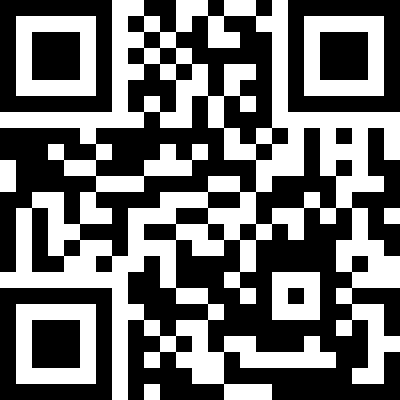